# Build a self-attention Transformer model

In this notebook, we will build the Transformer model for the classification task. The main architecture of the Transformer is derived from the paper: https://arxiv.org/pdf/1706.03762.pdf, but to be able to perform text classification we have to re-build the model a bit by applying the Max or Avg Pooling according to https://arxiv.org/pdf/1705.02364.pdf, where instead of using hidden representations we will us the last Transfomer block output.

The Transformer is solely based on the self-attention mechanism, disposing recurrent units or convolution layers at all, thanks to which that architecture is superior in terms of the prediction quality and the training time. The Transformer allows for significantly more parallelization and keeps also the ability of discerning long-term dependencies. To increase the generalization performance of the model we will use the label smoothing method.

The model is going to be trained on the clean_review column from the training dataset. In the end, the model will be evaluated on the test set to determine the generalization error.

We will perform the hyperparameter fine-tuning and visualize model's learning curves to compare the model's performance while working on different set of parameters. 

#### Self-attention

Attention is a function that maps the lineary transformed input sequence represented as three vectors - the query, the key and the value to the output vector. The output is calculated as a weighted sum of the values, where the weights are computed using compatibility function of queries and keys.

The first step is to create the three aforementioned vectors by multiplying the embedding vector of each word (including positional encoding or embedding) by three weight matrices that are learned during training. The second dimension of these matrices can be of an arbitrary shape, this enables us to use query, key and value vectors with different dimensionality than the input embedding vector.

<p><center>
$q_{i} = W_{q} \cdot x_{i} \quad k_{i} = W_{k} \cdot x_{i} \quad v_{i} = W_{v} \cdot x_{i}$
</center></p>
Where $x_{i}$ is the embedding vector and $W_{q}, W_{k}, W_{v}$ are the queries, keys and values weight matrices respectively.

Next the score is obtained by using the alignment function (dot product). The score is calculated between a query vector that corresponds to the word for which we would like to compute the output and all the key vectors. To prevent softmax from taking as an input to high values that might cause the gradient vanishing problem we have to scale the dot product by dividing it by the square root of the lenght of the query/key vector. 
<p><center>
$score = \frac{q_{i}^T \cdot\: k_{j}}{\sqrt{k_{dim}}}$
</center></p>
Where $k_{dim}$ is the key (query) vector dimension.

Then all the scores are run through the softmax layer that makes that all of them are in the range from 0 through 1 and ensures that they add up to 1. Softmaxed score at given position is then multiply by the corresponding value vector. Next all the resulted vectors are summed up to produce the context vector that contains the information about how much attention to pay to each of the input words to predict the output at given position.

<div>
<img src="assets/Dot-product-attention.png" width="1000"/>
</div>
<p><center>
Schema of Scaled Dot-Product Self-Attention for the word "this". 
</center></p>

#### Multi-Head Attention

Multi-Head Attention is a mechanism introduced by https://arxiv.org/pdf/1706.03762.pdf that takes into consideration the fact that different words can have a different meaning to their adjacent words, which improves the model's ability to focus on a different part of an input sequence. Instead of performing single attention that sums all information together, which may cause that two similar sentences will have the same meaning for the model (what should not happen), we conduct self-attention operation *h* times in parallel, while each head (single attention) has its own different, randomly initialized weight matrices $W_{q}, W_{k}, W_{v}$. The resulted context vectors of each attention head are concatenated and multiplied by the additional weight matrix during linear transformation to the lower dimensional space.

<br>
<div>
<img src="assets/multi-head-attention.png" width="220"/>
</div>
<p><center>
    Multi-Head Attention with <i>h</i> heads [https://arxiv.org/pdf/1706.03762.pdf]
</center></p>

#### Positional Encoding

The model's layers presented up to this time don't take into account the order of the words, they don't treat inputs as a sequence, but rather as a set, thus if we shuffle words in an input sequence we will obtain the same classification. To introduce into the model the possibility of including the order of words in its predictions, it is necessary to add the positional encoding or positional embedding layer to the architecture.

In this implementation we will use the positional encoding that has the edge over the embedding, namely, it uses a function that maps words positions to vectors, thus it can be used also to encode words positions in sequences that are longer than those seen during training thanks to the extrapolation possibility.

The sine and cosine functions can be used to encode words positions (use *sin* for even dimensions and *cos* for odd dimensions):
<p><center>
$PE_{(pos, 2i)} = sin(pos/10000^{2i/d_{model}})$ <br>
$PE_{(pos, 2i+1)} = cos(pos/10000^{2i/d_{model}})$
</center></p>

Where *pos* is the position, *i* is the dimension and $d_{model}$ is the dimensionality of the positional encoding vector that equals word embedding vector shape.

After creating positional encoding vector, it is summed together with the word embedding vector and passed to the first self-attention layer. In addition, we can apply dropout to the sum of these vectors before passing them forward. 

#### Label smoothing

Label smoothing is a method that improves the generalization performance of the model by computing cross entropy with a weighted compound of targets with the uniform distribution, instead of using the “hard" targets from the dataset.

The soft targets are computed according to the following formula:<br>
<p><center>
$y_{k}^{LS} = \begin{cases} 1 - \alpha & correct\:labels\\\alpha / (k-1) & wrong\:labels\end{cases}$
</center></p>
    
Where $\alpha$ is the smoothing parameter and *k* corresponds to the number of classes.

Then the target's vector is one-hot encoded using soft labels.

    label_smoothing/(output_size-1) = 0.1
    confidence = 1 - 0.1 = 0.9
        
    True labels      Smoothed one-hot labels
        |0|              [0.9000, 0.1000]
        |0|              [0.9000, 0.1000]
        |1|              [0.1000, 0.9000]
        |1|    label     [0.1000, 0.9000]
        |0|  smoothing   [0.9000, 0.1000]
        |1|    ---->     [0.1000, 0.9000]
        |0|              [0.9000, 0.1000]
        |0|              [0.9000, 0.1000]
        |0|              [0.9000, 0.1000]
        |1|              [0.1000, 0.9000]
        
The label smoothing encourages the model to decrease its confidence while predicting the correct labels because it uses the modified labels for correct examples, that are smaller than one (1 - $\alpha$), thus we will penalize the model from predicting too confidently (when confidence starting to rise above 1 - $\alpha$ threshold).

#### Transformer block

The Transformer architecture is composed of several identical layers that can be repeated, we call the set of these layers a block. Each block consists of the following layers: Multi-Head-Attention, layer normalization, position-wise fully connected feed-forward network and as the last one, another layer normalization. Around Multi-Head-Attention and Position-wise FFN the residual connections are used. The layer normalization is applied over the embedding dimension only. 
 
<br>
<div>
<img src="assets/transformer-block.png" width="280"/>
</div>
<p><center>
    Single Transformer block
</center></p>

#### Transformer for classification - architecture

The original model presented in the "Attention Is All You Need" has an encoder-decoder structure, which is used for seq2seq transformations. To prepare the Transformer for classification purposes we will take the similar approach we took when building the biGRU model, namely, we will apply the maximum or average pooling over the output of last Transformer block, instead of over hidden states. Then the pooled representation will be mapped to the softmaxed class tensor.

<br>
<div>
<img src="assets/Transformer-classifier.png" width="290"/>
</div>
<p><center>
    Schema of the Transformer model for classification tasks.
</center></p>

### Building and training the model

Let's start with importing all indispensable libraries.

In [1]:
from batch_iterator import BatchIterator
from early_stopping import EarlyStopping
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import device
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorboardX import SummaryWriter

To train the model we will use the clean_review column from the training set as well as the label column.

In [3]:
# Import the dataset. Use clean_review and label columns
train_dataset = pd.read_csv('dataset/drugreview_feat_clean/train_feat_clean.csv', 
                            usecols=['clean_review', 'rating'])

# Change columns order
train_dataset['label'] = train_dataset.rating >= 5
train_dataset = train_dataset[['clean_review', 'label']]

In [4]:
# Depict the first 5 rows of the training set
train_dataset = train_dataset.dropna()
train_dataset.head()

,clean_review,label
2,young suffering severe extreme neck pain resul...,True
5,found work helping good nights sleep don&#039;...,True
9,given medication gastroenterologist office wor...,False
12,recently laparoscopic hysterectomy know anesth...,True
13,mirena year experienced effects effects watch ...,False


To fine-tune the hyperparameters we will evaluate the model on a validation set.

In [6]:
# Import the dataset. Use clean_review and label columns
val_dataset = pd.read_csv('dataset/drugreview_feat_clean/val_feat_clean.csv',
                          usecols=['clean_review', 'rating'])

# Change columns order
val_dataset['label'] = val_dataset.rating >= 5
val_dataset = val_dataset[['clean_review', 'label']]

In [7]:
# Depict the first 5 rows of the validation set
val_dataset = val_dataset.dropna()
val_dataset.head()

,clean_review,label
0,year old son took night went deep sea fishing ...,True
1,daughter epiduo grade junior year work wonders...,True
2,i&#039;ve implant months day got totally felt ...,True
3,wanted wait days post couldn&#039;t results am...,True
4,colonoscopy best prep far morning took prep pm...,True


Now we will use the BatchIterator class to preprocess the text data and generate batches.

In [8]:
batch_size = 32

In [9]:
train_iterator = BatchIterator(train_dataset, batch_size=batch_size, vocab_created=False, vocab=None, target_col=None,
                               word2index=None, sos_token='<SOS>', eos_token='<EOS>', unk_token='<UNK>',
                               pad_token='<PAD>', min_word_count=3, max_vocab_size=None, max_seq_len=0.9,
                               use_pretrained_vectors=False, glove_path='glove/', glove_name='glove.6B.100d.txt',
                               weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
8674/21861 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 58
Mapped words to indices
Batches created


In [10]:
val_iterator = BatchIterator(val_dataset, batch_size=batch_size, vocab_created=False, vocab=None, target_col=None,
                             word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                             unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                             max_seq_len=0.9, use_pretrained_vectors=False, glove_path='glove/',
                             glove_name='glove.6B.100d.txt', weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
4655/11853 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 57
Mapped words to indices
Batches created


Now we will check out if the batches look correctly.

In [11]:
for batches in train_iterator:
    # Unpack the dictionary of batches
    input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
    print('input_seq shape: ', input_seq.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([32, 9])
target shape:  torch.Size([32])
x_lengths shape:  torch.Size([32])


In [12]:
# Extract the maximum sequence length

max_len = 0

for batches in train_iterator:
    x_lengths = batches['x_lengths']
    if max(x_lengths) > max_len:
        max_len = int(max(x_lengths))

In [13]:
print('Maximum sequence length: {}'.format(max_len))

Maximum sequence length: 59


Let's start implementing the Transformer model.

In [14]:
class MultiHeadAttention(nn.Module):
    """Implementation of the Multi-Head-Attention.
        
    Parameters
    ----------
    dmodel: int
        Dimensionality of the input embedding vector.
    heads: int
        Number of the self-attention operations to conduct in parallel. 
    """
    
    def __init__(self, dmodel, heads):
        
        super(MultiHeadAttention, self).__init__()
        
        assert dmodel % heads == 0, 'Embedding dimension is not divisible by number of heads'
            
        self.dmodel = dmodel
        self.heads = heads
        # Split dmodel (embedd dimension) into 'heads' number of chunks
        # each chunk of size key_dim will be passed to different attention head
        self.key_dim = dmodel // heads
        
        # keys, queries and values will be computed at once for all heads
        self.linear = nn.ModuleList([
            nn.Linear(self.dmodel, self.dmodel, bias=False),
            nn.Linear(self.dmodel, self.dmodel, bias=False),
            nn.Linear(self.dmodel, self.dmodel, bias=False)])
        
        self.concat = nn.Linear(self.dmodel, self.dmodel, bias=False)
        
        
    def forward(self, inputs):
        """ Perform Multi-Head-Attention.
        
        Parameters
        ----------
        inputs: torch.Tensor
            Batch of inputs - position encoded word embeddings ((batch_size, seq_length, embedding_dim)
            
        Returns
        -------
        torch.Tensor
            Multi-Head-Attention output of a shape (batch_size, seq_len, dmodel)
        """
        
        self.batch_size = inputs.size(0)
        
        assert inputs.size(2) == self.dmodel, 'Input sizes mismatch, dmodel={}, while embedd={}'\
            .format(self.dmodel, inputs.size(2))

        # Inputs shape (batch_size, seq_length, embedding_dim)        
        # Map input batch allong embedd dimension to query, key and value vectors with
        # a shape of (batch_size, heads, seq_len, key_dim (dmodel // heads)) 
        # where 'heads' dimension corresponds o different attention head
        query, key, value = [linear(x).view(self.batch_size, -1, self.heads, self.key_dim).transpose(1, 2)\
                             for linear, x in zip(self.linear, (inputs, inputs, inputs))]
        
        # Calculate the score (batch_size, heads, seq_len, seq_len)
        # for all heads at once
        score = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(self.key_dim)
        
        # Apply softmax to scores (batch_size, heads, seq_len, seq_len) 
        soft_score = F.softmax(score, dim = -1)
        
        # Multiply softmaxed score and value vector
        # value input shape (batch_size, heads, seq_len, key_dim)
        # out shape (batch_size, seq_len, dmodel (key_dim * heads))
        out = torch.matmul(soft_score, value).transpose(1, 2).contiguous()\
            .view(self.batch_size, -1, self.heads * self.key_dim)
        
        # Concatenate and linearly transform heads to the lower dimensional space
        # out shape (batch_size, seq_len, dmodel)
        out = self.concat(out)
        
        return out
        
        
class PositionalEncoding(nn.Module):
    """Implementation of the positional encoding.
    
    Parameters
    ----------
    max_len: int
        The maximum expected sequence length.
    dmodel: int
        Dimensionality of the input embedding vector.
    dropout: float
        Probability of an element of the tensor to be zeroed.
    padding_idx: int
        Index of the padding token in the vocabulary and word embedding.

    """
    
    def __init__(self, max_len, dmodel, dropout, padding_idx):
        
        super(PositionalEncoding, self).__init__()
                
        self.dropout = nn.Dropout(dropout)
        
        # Create pos_encoding, positions and dimensions matrices
        # with a shape of (max_len, dmodel)
        self.pos_encoding = torch.zeros(max_len, dmodel)
        positions = torch.repeat_interleave(torch.arange(float(max_len)).unsqueeze(1), dmodel, dim=1)
        dimensions = torch.arange(float(dmodel)).repeat(max_len, 1)
                                  
        # Calculate the encodings trigonometric function argument (max_len, dmodel)
        trig_fn_arg = positions / (torch.pow(10000, 2 * dimensions / dmodel))
               
        # Encode positions using sin function for even dimensions and
        # cos function for odd dimensions
        self.pos_encoding[:, 0::2] = torch.sin(trig_fn_arg[:, 0::2])
        self.pos_encoding[:, 1::2] = torch.cos(trig_fn_arg[:, 1::2])
        
        # Set the padding positional encoding to zero tensor
        if padding_idx:
            self.pos_encoding[padding_idx] = 0.0
        
        # Add batch dimension
        self.pos_encoding = self.pos_encoding.unsqueeze(0)
        
        
    def forward(self, embedd):
        """Apply positional encoding.
    
        Parameters
        ----------
        embedd: torch.Tensor
            Batch of word embeddings ((batch_size, seq_length, dmodel = embedding_dim))
        
        Returns
        -------
        torch.Tensor
            Sum of word embeddings and positional embeddings (batch_size, seq_length, dmodel)
        """
        
        # embedd shape (batch_size, seq_length, embedding_dim)
        # pos_encoding shape (1, max_len, dmodel = embedd_dim)
        embedd = embedd + self.pos_encoding[:, :embedd.size(1), :]
        embedd = self.dropout(embedd)
        
        # embedd shape (batch_size, seq_length, embedding_dim)
        return embedd  
    
    
class LabelSmoothingLoss(nn.Module):
    """Implementation of label smoothing with the Kullback-Leibler divergence Loss.
    
    Example:
    label_smoothing/(output_size-1) = 0.1
    confidence = 1 - 0.1 = 0.9
        
    True labels      Smoothed one-hot labels
        |0|              [0.9000, 0.1000]
        |0|              [0.9000, 0.1000]
        |1|              [0.1000, 0.9000]
        |1|    label     [0.1000, 0.9000]
        |0|  smoothing   [0.9000, 0.1000]
        |1|    ---->     [0.1000, 0.9000]
        |0|              [0.9000, 0.1000]
        |0|              [0.9000, 0.1000]
        |0|              [0.9000, 0.1000]
        |1|              [0.1000, 0.9000]
            
    Parameters
    ----------
    output_size: int
         The number of classes.
    label_smoothing: float, optional (default=0)
        The smoothing parameter. Takes the value in range [0,1].
    
    """
    
    def __init__(self, output_size, label_smoothing=0):

        super(LabelSmoothingLoss, self).__init__()
        
        self.output_size = output_size
        self.label_smoothing = label_smoothing
        self.confidence = 1 - self.label_smoothing
        
        assert label_smoothing >= 0.0 and label_smoothing <= 1.0, \
        'Label smoothing parameter takes values in the range [0, 1]'

        self.criterion = nn.KLDivLoss()
        
        
    def forward(self, pred, target):
        """Smooth the target labels and calculate the Kullback-Leibler divergence loss.
        
        Parameters
        ----------
        pred: torch.Tensor
            Batch of log-probabilities (batch_size, output_size)
        target: torch.Tensor
            Batch of target labels (batch_size, seq_length)
            
        Returns
        -------
        torch.Tensor
            The Kullback-Leibler divergence Loss.
    
        """
        # Create a Tensor of targets probabilities of a shape that equals 'pred' dimensions, filled all
        # with label_smoothing/(output_size-1) value that will correspond to the wrong label probability.
        one_hot_probs = torch.full(size=pred.size(), fill_value=self.label_smoothing/(self.output_size - 1))
        
        # Fill the tensor at positions that correspond to the true label from the target vector (0/1)
        # with the modified value of maximum probability (confidence).
        one_hot_probs.scatter_(1, target.unsqueeze(1), self.confidence)
            
        # KLDivLoss takes inputs (pred) that contain log-probs and targets given as probs (one_hot_probs).
        return self.criterion(pred, one_hot_probs)    


In [15]:
class TransformerBlock(nn.Module):
    """Implementation of single Transformer block.
    
    Transformer block structure:
    x --> Multi-Head --> Layer normalization --> Pos-Wise FFNN --> Layer normalization --> y
      |   Attention   |                       |                 |
      |_______________|                       |_________________|
     residual connection                      residual connection
    
    Parameters
    ----------
    dmodel: int
        Dimensionality of the input embedding vector.
    ffnn_hidden_size: int
        Position-Wise-Feed-Forward Neural Network hidden size.
    heads: int
        Number of the self-attention operations to conduct in parallel.
    dropout: float
        Probability of an element of the tensor to be zeroed.
    """
    
    def __init__(self, dmodel, ffnn_hidden_size, heads, dropout):
        
        super(TransformerBlock, self).__init__()
        
        self.attention = MultiHeadAttention(dmodel, heads)
        self.layer_norm1 = nn.LayerNorm(dmodel)
        self.layer_norm2 = nn.LayerNorm(dmodel)
        
        self.ffnn = nn.Sequential(
                nn.Linear(dmodel, ffnn_hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(ffnn_hidden_size, dmodel))
        
        
    def forward(self, inputs):
        """Forward propagate through the Transformer block.

        Parameters
        ----------
        inputs: torch.Tensor
            Batch of embeddings.
            
        Returns
        -------
        torch.Tensor
            Output of the Transformer block (batch_size, seq_length, dmodel)
        """
        # Inputs shape (batch_size, seq_length, embedding_dim = dmodel)
        output = inputs + self.attention(inputs)            
        output = self.layer_norm1(output)            
        output = output + self.ffnn(output)            
        output = self.layer_norm2(output)

        # Output shape (batch_size, seq_length, dmodel)
        return output
        
        
class Transformer(nn.Module):
    """Implementation of the Transformer model for classification.
    
    Parameters
    ----------
    vocab_size: int
        The size of the vocabulary.
    dmodel: int
        Dimensionality of the embedding vector.
    max_len: int
        The maximum expected sequence length.
    padding_idx: int, optional (default=0)
        Index of the padding token in the vocabulary and word embedding.
    n_layers: int, optional (default=4)
        Number of the stacked Transformer blocks.    
    ffnn_hidden_size: int, optonal (default=dmodel * 4)
        Position-Wise-Feed-Forward Neural Network hidden size.
    heads: int, optional (default=8)
        Number of the self-attention operations to conduct in parallel.
    pooling: str, optional (default='max')
        Specify the type of pooling to use. Available options: 'max' or 'avg'.
    dropout: float, optional (default=0.2)
        Probability of an element of the tensor to be zeroed.
    """
    
    def __init__(self, vocab_size, dmodel, output_size, max_len, padding_idx=0, n_layers=4,
                 ffnn_hidden_size=None, heads=8, pooling='max', dropout=0.2):
        
        super(Transformer, self).__init__()
        
        if not ffnn_hidden_size:
            ffnn_hidden_size = dmodel * 4
            
        assert pooling == 'max' or pooling == 'avg', 'Improper pooling type was passed.'
        
        self.pooling = pooling
        self.output_size = output_size
        
        self.embedding = nn.Embedding(vocab_size, dmodel)
        
        self.pos_encoding = PositionalEncoding(max_len, dmodel, dropout, padding_idx)
        
        self.tnf_blocks = nn.ModuleList()
        
        for n in range(n_layers):
            self.tnf_blocks.append(
                TransformerBlock(dmodel, ffnn_hidden_size, heads, dropout))
            
        self.tnf_blocks = nn.Sequential(*self.tnf_blocks)
            
        self.linear = nn.Linear(dmodel, output_size)
        
        
    def forward(self, inputs, input_lengths):
        """Forward propagate through the Transformer.
        
        Parameters
        ----------
        inputs: torch.Tensor
            Batch of input sequences.
        input_lengths: torch.LongTensor
            Batch containing sequences lengths.
            
        Returns
        -------
        torch.Tensor
            Logarithm of softmaxed class tensor.
        """
        self.batch_size = inputs.size(0)
        
        # Input dimensions (batch_size, seq_length, dmodel)
        output = self.embedding(inputs)
        output = self.pos_encoding(output)
        output = self.tnf_blocks(output)
        # Output dimensions (batch_size, seq_length, dmodel)
        
        if self.pooling == 'max':
            # Permute to the shape (batch_size, dmodel, seq_length)
            # Apply max-pooling, output dimensions (batch_size, dmodel)
            output = F.adaptive_max_pool1d(output.permute(0,2,1), (1,)).view(self.batch_size,-1)
        else:
            # Sum along the batch axis and divide by the corresponding lengths (FloatTensor)
            # Output shape: (batch_size, dmodel)
            output = torch.sum(output, dim=1) / input_lengths.view(-1,1).type(torch.FloatTensor) 
            
        output = self.linear(output)
        
        return F.log_softmax(output, dim=-1)
        
        
    def add_loss_fn(self, loss_fn):
        """Add loss function to the model.
        
        """
        self.loss_fn = loss_fn
        

    def add_optimizer(self, optimizer):
        """Add optimizer to the model.
        
        """
        self.optimizer = optimizer
        
        
    def add_device(self, device=torch.device('cpu')):
        """Specify the device.
        
        """
        self.device = device
    
    
    def train_model(self, train_iterator):
        """Perform single training epoch.
        
        Parameters
        ----------
        train_iterator: BatchIterator
            BatchIterator class object containing training batches.
            
        Returns
        -------
        train_losses: list
            List of the training average batch losses.
        avg_loss: float
            Average loss on the entire training set.
        accuracy: float
            Models accuracy on the entire training set.
            
        """
        self.train()
        
        train_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
            
        for i, batches in tqdm_notebook(enumerate(train_iterator, 1), total=len(train_iterator), desc='Training'):
            input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
            
            input_seq.to(self.device)
            target.to(self.device)
            x_lengths.to(self.device)
            
            self.optimizer.zero_grad()

            pred = self.forward(input_seq, x_lengths)
            loss = self.loss_fn(pred, target)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()
            
            losses_list.append(loss.data.cpu().numpy())
            
            pred = torch.argmax(pred, 1)

            if self.device.type == 'cpu':
                batch_correct += (pred.cpu() == target.cpu()).sum().item()

            else:
                batch_correct += (pred == target).sum().item()

            num_seq += len(input_seq)     
    
            if i % 100 == 0:
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                
                accuracy = batch_correct / num_seq
                
                print('Iteration: {}. Average training loss: {:.4f}. Accuracy: {:.3f}'\
                      .format(i, avg_train_loss, accuracy))
                
                losses = []
                
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
                              
        return train_losses, avg_loss, accuracy
    
    
    def evaluate_model(self, eval_iterator, conf_mtx=False):
        """Perform the one evaluation epoch.
        
        Parameters
        ----------
        eval_iterator: BatchIterator
            BatchIterator class object containing evaluation batches.
        conf_mtx: boolean, optional (default=False)
            Whether to print the confusion matrix at each epoch.
            
        Returns
        -------
        eval_losses: list
            List of the evaluation average batch losses.
        avg_loss: float
            Average loss on the entire evaluation set.
        accuracy: float
            Models accuracy on the entire evaluation set.
        conf_matrix: list
            Confusion matrix.
            
        """
        self.eval()
        
        eval_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
        pred_total = torch.LongTensor()
        target_total = torch.LongTensor()
        
        with torch.no_grad():
            for i, batches in tqdm_notebook(enumerate(eval_iterator, 1), total=len(eval_iterator), desc='Evaluation'):
                input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
                
                input_seq.to(self.device)
                target.to(self.device)
                x_lengths.to(self.device)

                pred = self.forward(input_seq, x_lengths)
                loss = self.loss_fn(pred, target)
                losses.append(loss.data.cpu().numpy())
                losses_list.append(loss.data.cpu().numpy())
                
                pred = torch.argmax(pred, 1)
                                
                if self.device.type == 'cpu':
                    batch_correct += (pred.cpu() == target.cpu()).sum().item()
                    
                else:
                    batch_correct += (pred == target).sum().item()
                    
                num_seq += len(input_seq)     
                
                pred_total = torch.cat([pred_total, pred], dim=0)
                target_total = torch.cat([target_total, target], dim=0)
                
                if i % 100 == 0:
                    avg_batch_eval_loss = np.mean(losses)
                    eval_losses.append(avg_batch_eval_loss)
                    
                    accuracy = batch_correct / num_seq
                    
                    print('Iteration: {}. Average evaluation loss: {:.4f}. Accuracy: {:.2f}'\
                          .format(i, avg_batch_eval_loss, accuracy))

                    losses = []
                    
            avg_loss_list = []
                    
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
            
            conf_matrix = confusion_matrix(target_total.view(-1), pred_total.view(-1))
        
        if conf_mtx:
            print('\tConfusion matrix: ', conf_matrix)
            
        return eval_losses, avg_loss, accuracy, conf_matrix
    

In [16]:
# Initialize parameters
vocab_size = len(train_iterator.word2index)
dmodel = 64
output_size = 2
padding_idx = train_iterator.word2index['<PAD>']
n_layers = 4
ffnn_hidden_size = dmodel * 2
heads = 8
pooling = 'max'
dropout = 0.5
label_smoothing = 0.1
learning_rate = 0.001
epochs = 30

# Check whether system supports CUDA
CUDA = torch.cuda.is_available()

model = Transformer(vocab_size, dmodel, output_size, max_len, padding_idx, n_layers,\
                    ffnn_hidden_size, heads, pooling, dropout)

# Move the model to GPU if possible
if CUDA:
    model.cuda()
    
# Add loss function    
if label_smoothing:
    loss_fn = LabelSmoothingLoss(output_size, label_smoothing)
else:
    loss_fn = nn.NLLLoss()
    
model.add_loss_fn(loss_fn)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.add_optimizer(optimizer)

device = torch.device('cuda' if CUDA else 'cpu')

model.add_device(device)

# Create the parameters dictionary and instantiate the tensorboardX SummaryWriter
params = {'batch_size': batch_size,
          'dmodel': dmodel,
          'n_layers': n_layers,
          'ffnn_hidden_size': ffnn_hidden_size,
          'heads': heads,
          'pooling': pooling,
          'dropout': dropout,
          'label_smoothing': label_smoothing,
          'learning_rate': learning_rate}

train_writer = SummaryWriter(comment=f' Training, batch_size={batch_size}, dmodel={dmodel}, n_layers={n_layers},\
ffnn_hidden_size={ffnn_hidden_size}, heads={heads}, pooling={pooling}, dropout={dropout}, \
label_smoothing={label_smoothing}, learning_rate={learning_rate}'.format(**params))

val_writer = SummaryWriter(comment=f' Validation, batch_size={batch_size}, dmodel={dmodel}, n_layers={n_layers},\
ffnn_hidden_size={ffnn_hidden_size}, heads={heads}, pooling={pooling}, dropout={dropout}, \
label_smoothing={label_smoothing}, learning_rate={learning_rate}'.format(**params))

# Instantiate the EarlyStopping
early_stop = EarlyStopping(wait_epochs=3)

train_losses_list, train_avg_loss_list, train_accuracy_list = [], [], []
eval_avg_loss_list, eval_accuracy_list, conf_matrix_list = [], [], []

for epoch in range(epochs):
    
    try:
        print('\nStart epoch [{}/{}]'.format(epoch+1, epochs))

        train_losses, train_avg_loss, train_accuracy = model.train_model(train_iterator)

        train_losses_list.append(train_losses)
        train_avg_loss_list.append(train_avg_loss)
        train_accuracy_list.append(train_accuracy)

        _, eval_avg_loss, eval_accuracy, conf_matrix = model.evaluate_model(val_iterator)

        eval_avg_loss_list.append(eval_avg_loss)
        eval_accuracy_list.append(eval_accuracy)
        conf_matrix_list.append(conf_matrix)

        print('\nEpoch [{}/{}]: Train accuracy: {:.3f}. Train loss: {:.4f}. Evaluation accuracy: {:.3f}. Evaluation loss: {:.4f}'\
              .format(epoch+1, epochs, train_accuracy, train_avg_loss, eval_accuracy, eval_avg_loss))

        train_writer.add_scalar('Training loss', train_avg_loss, epoch)
        val_writer.add_scalar('Validation loss', eval_avg_loss, epoch)

        if early_stop.stop(eval_avg_loss, model, delta=0.003):
            break

    finally:
        train_writer.close()
        val_writer.close()



Start epoch [1/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1505. Accuracy: 0.733
Iteration: 200. Average training loss: 0.1446. Accuracy: 0.742
Iteration: 300. Average training loss: 0.1452. Accuracy: 0.744
Iteration: 400. Average training loss: 0.1405. Accuracy: 0.745


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.1303. Accuracy: 0.76

Epoch [1/30]: Train accuracy: 0.746. Train loss: 0.1444. Evaluation accuracy: 0.757. Evaluation loss: 0.1312

Start epoch [2/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1366. Accuracy: 0.741
Iteration: 200. Average training loss: 0.1355. Accuracy: 0.746
Iteration: 300. Average training loss: 0.1376. Accuracy: 0.746
Iteration: 400. Average training loss: 0.1297. Accuracy: 0.747


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.1222. Accuracy: 0.76

Epoch [2/30]: Train accuracy: 0.746. Train loss: 0.1340. Evaluation accuracy: 0.757. Evaluation loss: 0.1227

Start epoch [3/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1292. Accuracy: 0.753
Iteration: 200. Average training loss: 0.1257. Accuracy: 0.758
Iteration: 300. Average training loss: 0.1282. Accuracy: 0.758
Iteration: 400. Average training loss: 0.1225. Accuracy: 0.759


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.1122. Accuracy: 0.79

Epoch [3/30]: Train accuracy: 0.762. Train loss: 0.1256. Evaluation accuracy: 0.796. Evaluation loss: 0.1117

Start epoch [4/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1200. Accuracy: 0.779
Iteration: 200. Average training loss: 0.1201. Accuracy: 0.776
Iteration: 300. Average training loss: 0.1248. Accuracy: 0.772
Iteration: 400. Average training loss: 0.1159. Accuracy: 0.774


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.1085. Accuracy: 0.80

Epoch [4/30]: Train accuracy: 0.776. Train loss: 0.1197. Evaluation accuracy: 0.801. Evaluation loss: 0.1083

Start epoch [5/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1140. Accuracy: 0.785
Iteration: 200. Average training loss: 0.1143. Accuracy: 0.787
Iteration: 300. Average training loss: 0.1186. Accuracy: 0.785
Iteration: 400. Average training loss: 0.1096. Accuracy: 0.786


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.1045. Accuracy: 0.81

Epoch [5/30]: Train accuracy: 0.787. Train loss: 0.1135. Evaluation accuracy: 0.809. Evaluation loss: 0.1045

Start epoch [6/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1058. Accuracy: 0.808
Iteration: 200. Average training loss: 0.1116. Accuracy: 0.801
Iteration: 300. Average training loss: 0.1096. Accuracy: 0.801
Iteration: 400. Average training loss: 0.1057. Accuracy: 0.800


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.1019. Accuracy: 0.81

Epoch [6/30]: Train accuracy: 0.801. Train loss: 0.1075. Evaluation accuracy: 0.812. Evaluation loss: 0.1019

Start epoch [7/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1044. Accuracy: 0.808
Iteration: 200. Average training loss: 0.1050. Accuracy: 0.806
Iteration: 300. Average training loss: 0.1070. Accuracy: 0.804
Iteration: 400. Average training loss: 0.0995. Accuracy: 0.808


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0992. Accuracy: 0.82

Epoch [7/30]: Train accuracy: 0.808. Train loss: 0.1035. Evaluation accuracy: 0.820. Evaluation loss: 0.0993

Start epoch [8/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1017. Accuracy: 0.812
Iteration: 200. Average training loss: 0.1003. Accuracy: 0.814
Iteration: 300. Average training loss: 0.1053. Accuracy: 0.814
Iteration: 400. Average training loss: 0.0985. Accuracy: 0.816


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0992. Accuracy: 0.82

Epoch [8/30]: Train accuracy: 0.816. Train loss: 0.1016. Evaluation accuracy: 0.818. Evaluation loss: 0.0995

Start epoch [9/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0961. Accuracy: 0.826
Iteration: 200. Average training loss: 0.1001. Accuracy: 0.821
Iteration: 300. Average training loss: 0.1035. Accuracy: 0.819
Iteration: 400. Average training loss: 0.0966. Accuracy: 0.821


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0965. Accuracy: 0.82

Epoch [9/30]: Train accuracy: 0.822. Train loss: 0.0983. Evaluation accuracy: 0.820. Evaluation loss: 0.0966

Start epoch [10/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0938. Accuracy: 0.825
Iteration: 200. Average training loss: 0.0979. Accuracy: 0.822
Iteration: 300. Average training loss: 0.0984. Accuracy: 0.820
Iteration: 400. Average training loss: 0.0900. Accuracy: 0.825


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0965. Accuracy: 0.82

Epoch [10/30]: Train accuracy: 0.827. Train loss: 0.0940. Evaluation accuracy: 0.816. Evaluation loss: 0.0968

Start epoch [11/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0888. Accuracy: 0.842
Iteration: 200. Average training loss: 0.0918. Accuracy: 0.837
Iteration: 300. Average training loss: 0.0941. Accuracy: 0.834
Iteration: 400. Average training loss: 0.0900. Accuracy: 0.834


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0960. Accuracy: 0.83

Epoch [11/30]: Train accuracy: 0.837. Train loss: 0.0904. Evaluation accuracy: 0.825. Evaluation loss: 0.0966

Start epoch [12/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0881. Accuracy: 0.844
Iteration: 200. Average training loss: 0.0918. Accuracy: 0.840
Iteration: 300. Average training loss: 0.0931. Accuracy: 0.839
Iteration: 400. Average training loss: 0.0877. Accuracy: 0.839


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0945. Accuracy: 0.82

Epoch [12/30]: Train accuracy: 0.841. Train loss: 0.0892. Evaluation accuracy: 0.824. Evaluation loss: 0.0947

Start epoch [13/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0900. Accuracy: 0.838
Iteration: 200. Average training loss: 0.0878. Accuracy: 0.839
Iteration: 300. Average training loss: 0.0936. Accuracy: 0.836
Iteration: 400. Average training loss: 0.0861. Accuracy: 0.840


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0943. Accuracy: 0.83

Epoch [13/30]: Train accuracy: 0.842. Train loss: 0.0881. Evaluation accuracy: 0.831. Evaluation loss: 0.0944

Start epoch [14/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0852. Accuracy: 0.851
Iteration: 200. Average training loss: 0.0859. Accuracy: 0.848
Iteration: 300. Average training loss: 0.0907. Accuracy: 0.844
Iteration: 400. Average training loss: 0.0829. Accuracy: 0.847


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0948. Accuracy: 0.83

Epoch [14/30]: Train accuracy: 0.848. Train loss: 0.0853. Evaluation accuracy: 0.827. Evaluation loss: 0.0944

Start epoch [15/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0847. Accuracy: 0.846
Iteration: 200. Average training loss: 0.0845. Accuracy: 0.847
Iteration: 300. Average training loss: 0.0871. Accuracy: 0.848
Iteration: 400. Average training loss: 0.0824. Accuracy: 0.849


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0936. Accuracy: 0.83

Epoch [15/30]: Train accuracy: 0.850. Train loss: 0.0833. Evaluation accuracy: 0.830. Evaluation loss: 0.0943

Start epoch [16/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0832. Accuracy: 0.852
Iteration: 200. Average training loss: 0.0833. Accuracy: 0.853
Iteration: 300. Average training loss: 0.0860. Accuracy: 0.852
Iteration: 400. Average training loss: 0.0807. Accuracy: 0.854


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0934. Accuracy: 0.83

Epoch [16/30]: Train accuracy: 0.854. Train loss: 0.0827. Evaluation accuracy: 0.828. Evaluation loss: 0.0938

Start epoch [17/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0789. Accuracy: 0.860
Iteration: 200. Average training loss: 0.0811. Accuracy: 0.858
Iteration: 300. Average training loss: 0.0823. Accuracy: 0.858
Iteration: 400. Average training loss: 0.0789. Accuracy: 0.858


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0932. Accuracy: 0.83

Epoch [17/30]: Train accuracy: 0.859. Train loss: 0.0790. Evaluation accuracy: 0.829. Evaluation loss: 0.0936

Start epoch [18/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0765. Accuracy: 0.867
Iteration: 200. Average training loss: 0.0789. Accuracy: 0.863
Iteration: 300. Average training loss: 0.0828. Accuracy: 0.860
Iteration: 400. Average training loss: 0.0755. Accuracy: 0.863


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0951. Accuracy: 0.82

Epoch [18/30]: Train accuracy: 0.865. Train loss: 0.0773. Evaluation accuracy: 0.825. Evaluation loss: 0.0956

Start epoch [19/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0763. Accuracy: 0.871
Iteration: 200. Average training loss: 0.0767. Accuracy: 0.870
Iteration: 300. Average training loss: 0.0787. Accuracy: 0.869
Iteration: 400. Average training loss: 0.0751. Accuracy: 0.869


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0943. Accuracy: 0.82

Epoch [19/30]: Train accuracy: 0.869. Train loss: 0.0762. Evaluation accuracy: 0.825. Evaluation loss: 0.0944

Start epoch [20/30]


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0773. Accuracy: 0.872
Iteration: 200. Average training loss: 0.0753. Accuracy: 0.867
Iteration: 300. Average training loss: 0.0816. Accuracy: 0.865
Iteration: 400. Average training loss: 0.0758. Accuracy: 0.866


Evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0965. Accuracy: 0.82

Epoch [20/30]: Train accuracy: 0.868. Train loss: 0.0762. Evaluation accuracy: 0.821. Evaluation loss: 0.0968

Training stoped by EarlyStopping


Below we will present validation learning curves of all training trials plotted by TensordBoard.

<br>
<div>
<img src="assets/Trns_lc_TensorBoard.png" width="800"/>
</div>
<p><center>
    Validation learning curves for the Transformer model (description below).
</center></p>


The tally of the three best hyperparameters sets is presented in the following table.

| Curve description | Hyperparameters set | Loss | Accuracy |
| :--- | :--- | :--- | :--- |
| The lowest pink curve | batch_size=64, dmodel=64, n_layers=6, ffnn_hidden_size=128, heads=8, dropout=0.5, learning_rate=0.001 | 0.0692 | 0.882 |
| The lowest blue curve | batch_size=32, dmodel=64, n_layers=6, ffnn_hidden_size=128, heads=4, dropout=0.5, learning_rate=0.001 | 0.0671 | 0.886 |
| The lowest orange curve | batch_size=32, dmodel=64, n_layers=4, ffnn_hidden_size=128, heads=8, dropout=0.5, learning_rate=0.001 | 0.0693 | 0.880 |

The orange curve listed in the above table corresponds to the current training process. The confusion matrix and generalization error will be also presented for the current training.

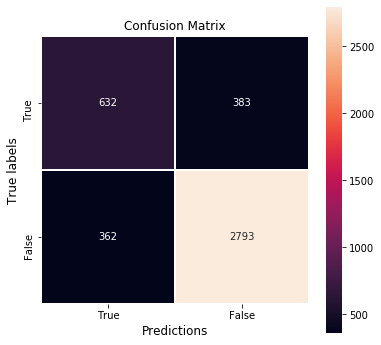

In [17]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

### The generalization error

In [19]:
# Import the dataset. Use clean_review and label columns
test_dataset = pd.read_csv('dataset/drugreview_feat_clean/test_feat_clean.csv',
                          usecols=['clean_review', 'rating'])

# Change columns order
test_dataset['label'] = 
test_dataset = test_dataset[['clean_review', 'label']]

In [20]:
test_dataset.head()

,clean_review,label
0,hear film till pop cable tv understand geena o...,1
1,know film show local tv kid remember watch see...,0
2,admire kiss mouth frankness  pubic hair cut m...,0
3,see cure kid love year late get hold copy acci...,1
4,movie true fact see documentary day early movi...,0


In [21]:
test_iterator = BatchIterator(test_dataset, batch_size=256, vocab_created=False, vocab=None, target_col=None,
                              word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                              unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                              max_seq_len=0.9, use_pretrained_vectors=False, glove_path='glove/',
                              glove_name='glove.6B.100d.txt', weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
13480/39104 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 187
Mapped words to indices
Batches created


In [22]:
_, test_avg_loss, test_accuracy, test_conf_matrix = model.evaluate_model(test_iterator)

In [23]:
print('Test accuracy: {:.3f}. Test error: {:.3f}'.format(test_accuracy, test_avg_loss))

Test accuracy: 0.883. Test error: 0.070


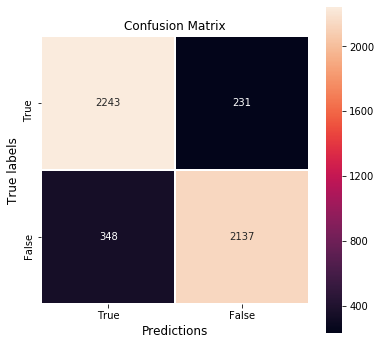

In [24]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(test_conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()